In [1]:
!pip install openpyxl



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.4 MB/s eta 0:00:00








In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from xgboost import XGBClassifier


In [3]:
train = pd.read_csv("../input/swell-heart-rate-variability-hrv/hrv dataset/data/final/train.csv")
test = pd.read_csv("../input/swell-heart-rate-variability-hrv/hrv dataset/data/final/test.csv")

<BarContainer object of 3 artists>

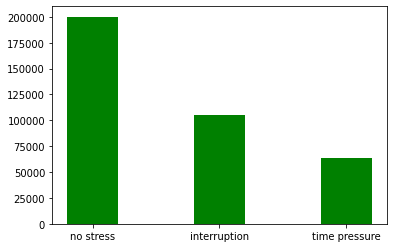

In [4]:
conditions = dict(train['condition'].value_counts())
labels = list(conditions.keys())
counts = list(conditions.values())
plt.bar(labels,counts, color ='green',width = 0.4)

In [5]:
le = preprocessing.LabelEncoder()
le.fit(train['condition'])
train['condition'] = le.transform(train['condition'])
e = test['condition'].unique()
test['condition'] = le.transform(test['condition'])

In [6]:
f = le.transform(e)
print(f)

[1 2 0]


In [7]:
g = le.inverse_transform(f)
print(g)
# 1 = no stress
# 2 = time pressure
# 0 = interruption

['no stress' 'time pressure' 'interruption']


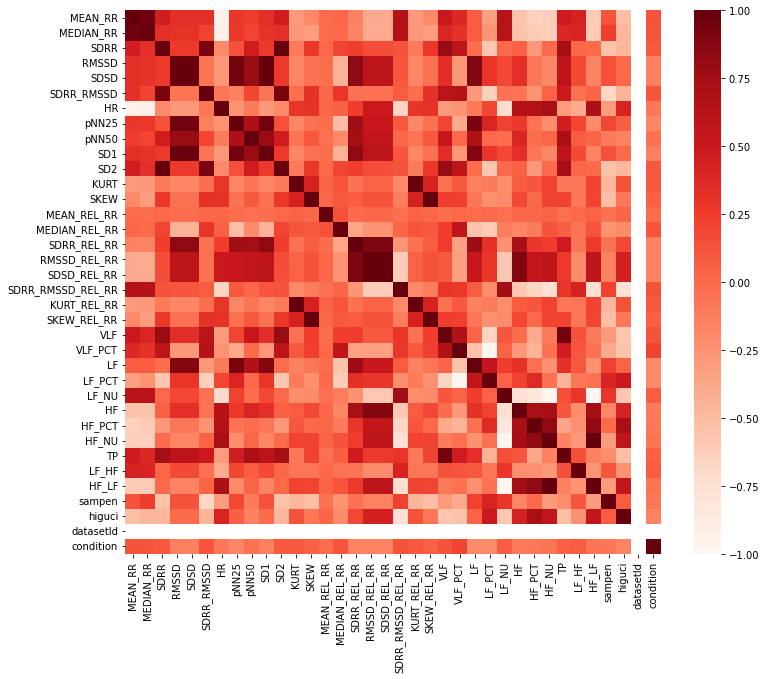

In [8]:
plt.figure(figsize=(12,10))
corr = train.corr()
sns.heatmap(corr, annot=False, cmap=plt.cm.Reds)
plt.show()

In [9]:
def feature_selection(correlation,threshold):
    selected_features = []
    for i in range(corr.shape[0]):
      if corr.iloc[i,35] > threshold:
        selected_features.append(train.iloc[:,i])
    return pd.DataFrame(selected_features).T

In [10]:
train.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
0,885.157845,853.763730,140.972741,15.554505,15.553371,9.063146,69.499952,11.133333,0.533333,11.001565,...,15.522603,0.421047,1.514737,3686.666157,65.018055,0.015380,2.139754,1.163485,2,1
1,939.425371,948.357865,81.317742,12.964439,12.964195,6.272369,64.363150,5.600000,0.000000,9.170129,...,2.108525,0.070133,0.304603,3006.487251,327.296635,0.003055,2.174499,1.084711,2,0
2,898.186047,907.006860,84.497236,16.305279,16.305274,5.182201,67.450066,13.066667,0.200000,11.533417,...,13.769729,0.512671,1.049528,2685.879461,94.280910,0.010607,2.135350,1.176315,2,0
3,881.757865,893.460030,90.370537,15.720468,15.720068,5.748591,68.809562,11.800000,0.133333,11.119476,...,18.181913,0.529387,1.775294,3434.520980,55.328701,0.018074,2.178341,1.179688,2,1
4,809.625331,811.184865,62.766242,19.213819,19.213657,3.266724,74.565728,20.200000,0.200000,13.590641,...,48.215822,1.839473,3.279993,2621.175204,29.487873,0.033912,2.221121,1.249612,2,1


In [11]:
CORRELATION_THRESHOLD = 0.1
nn_train = train.copy()
reduced_train = feature_selection(corr,CORRELATION_THRESHOLD)
reduced_train.head()

,MEAN_RR,MEDIAN_RR,SDRR_RMSSD,MEDIAN_REL_RR,SDRR_RMSSD_REL_RR,VLF,VLF_PCT,condition
0,885.157845,853.763730,9.063146,-0.000179,2.143342,2661.894136,72.203287,1.0
1,939.425371,948.357865,6.272369,0.000611,2.930855,2314.265450,76.975728,0.0
2,898.186047,907.006860,5.182201,-0.000263,2.127053,1373.887112,51.152225,0.0
3,881.757865,893.460030,5.748591,0.000494,2.050988,2410.357408,70.180308,1.0
4,809.625331,811.184865,3.266724,-0.002736,1.816544,1151.177330,43.918366,1.0


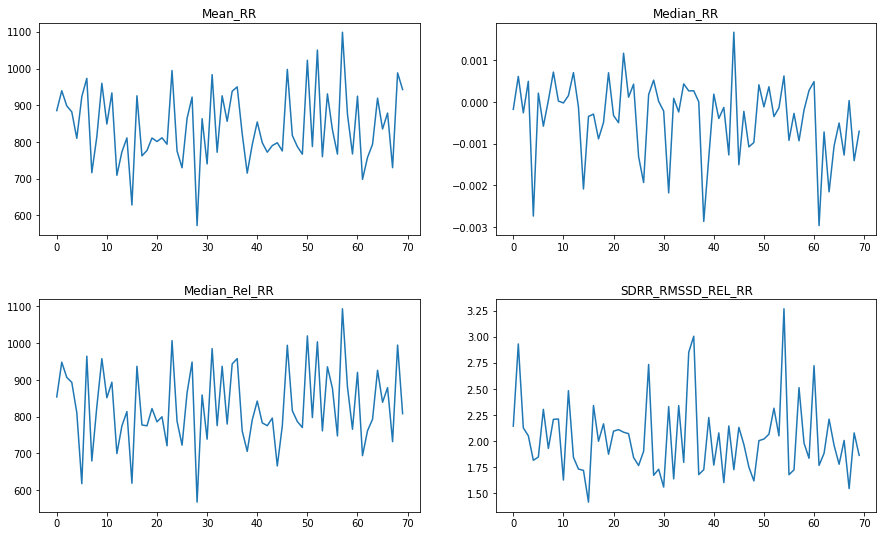

In [12]:
fig, axarr = plt.subplots(2, 2, figsize=(15, 9))
reduced_train['MEAN_RR'][:70].plot(ax=axarr[0][0])
reduced_train['MEDIAN_RR'][:70].plot(ax=axarr[1][0])
reduced_train['MEDIAN_REL_RR'][:70].plot(ax=axarr[0][1])
reduced_train['SDRR_RMSSD_REL_RR'][:70].plot(ax=axarr[1][1])
axarr[0][0].set_title("Mean_RR")
axarr[0][1].set_title("Median_RR")
axarr[1][0].set_title("Median_Rel_RR")
axarr[1][1].set_title("SDRR_RMSSD_REL_RR")
plt.subplots_adjust(hspace=.3)

<AxesSubplot:>

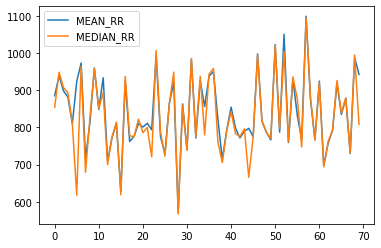

In [13]:
reduced_train[['MEAN_RR','MEDIAN_RR']][:70].plot()

In [14]:
x_train = reduced_train.iloc[:,:-1]
y_train = reduced_train.iloc[:,-1]

In [15]:
nn_x_train = nn_train.iloc[:,:-1]
nn_y_train = nn_train.iloc[:,-1]

In [16]:
nn_x_test = test[nn_x_train.columns]
x_test = test[x_train.columns]
y_test = test['condition']

In [17]:
# Initializing the ANN
ann = Sequential()
## Add the input layer and first hidden layer
ann.add(Dense(nn_x_train.shape[1], activation="relu", input_shape = (nn_x_train.shape[1],)))

ann.add(Dense(24))
ann.add(Activation('relu'))

ann.add(Dense(12))
ann.add(Activation('relu'))

ann.add(Dense(8))
ann.add(Activation('relu'))

ann.add(Dense(4))
ann.add(Activation('relu'))

ann.add(Dense(1, activation="softmax", kernel_initializer="normal"))
ann.summary()

ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ann.fit(nn_x_train, nn_y_train, epochs=3)

2022-07-05 13:37:21.141070: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


dense (Dense)                (None, 35)                1260      

_________________________________________________________________

dense_1 (Dense)              (None, 24)                864       

_________________________________________________________________

activation (Activation)      (None, 24)                0         

_________________________________________________________________

dense_2 (Dense)              (None, 12)                300       

_________________________________________________________________

activation_1 (Activation)    (None, 12)                0         

_________________________________________________________________

dense_3 (Dense)              (None, 8)                 104       

_________________________________________________________________

activation_2 (Activation)    (None, 8)  

2022-07-05 13:37:21.636995: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3

11541/11541 [==============================] - 34s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5418

Epoch 2/3

11541/11541 [==============================] - 30s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5418

Epoch 3/3

11541/11541 [==============================] - 30s 3ms/step - loss: 0.0000e+00 - accuracy: 0.5418


In [18]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)

RandomForestClassifier()

In [19]:
p = Perceptron(random_state=0)
p.fit(x_train, y_train)

Perceptron()

In [20]:
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=14)
dt_model = dt_model.fit(x_train,y_train)

In [21]:
ann_prediction = ann.predict(nn_x_test)
pct_prediction = p.predict(x_test)
rf_prediction = rf_model.predict(x_test)
dt_prediction = dt_model.predict(x_test)

In [22]:
#ann_prediction_prob = ann.predict_proba(nn_x_test)
#pct_prediction_prob = p.predict_proba(x_test)
#rf_prediction_prob = rf_model.predict_proba(x_test)
#dt_prediction_prob = dt_model.predict_proba(x_test)

**ANN**

In [23]:
print(classification_report(y_test,ann_prediction))

              precision    recall  f1-score   support



           0       0.00      0.00      0.00     11782

           1       0.54      1.00      0.70     22158

           2       0.00      0.00      0.00      7093



    accuracy                           0.54     41033

   macro avg       0.18      0.33      0.23     41033

weighted avg       0.29      0.54      0.38     41033




/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


**Perceptron**

In [24]:
print(classification_report(y_test,pct_prediction))

              precision    recall  f1-score   support



           0       0.46      0.47      0.47     11782

           1       0.59      0.78      0.67     22158

           2       0.00      0.00      0.00      7093



    accuracy                           0.55     41033

   macro avg       0.35      0.42      0.38     41033

weighted avg       0.45      0.55      0.50     41033




/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


**Random Forest**

In [25]:
print(classification_report(y_test,rf_prediction))

              precision    recall  f1-score   support



           0       1.00      1.00      1.00     11782

           1       1.00      1.00      1.00     22158

           2       1.00      1.00      1.00      7093



    accuracy                           1.00     41033

   macro avg       1.00      1.00      1.00     41033

weighted avg       1.00      1.00      1.00     41033




**Decision Tree**

In [26]:
print(classification_report(y_test,dt_prediction))

              precision    recall  f1-score   support



           0       0.99      0.95      0.97     11782

           1       0.96      0.99      0.98     22158

           2       0.97      0.94      0.96      7093



    accuracy                           0.97     41033

   macro avg       0.97      0.96      0.97     41033

weighted avg       0.97      0.97      0.97     41033




In [27]:
le.inverse_transform(test['condition'].unique())

array(['no stress', 'time pressure', 'interruption'], dtype=object)

In [28]:
#sheets_dict = pd.read_excel('../input/swell-heart-rate-variability-hrv/hrv dataset/data/raw/labels/hrv stress labels.xlsx', sheet_name=None)#
#
#signals = []
#all_sheets = []
#for name, sheet in sheets_dict.items():
#    sheet['sheet'] = name
#    sheet = sheet.rename(columns=lambda x: x.split('\n')[-1])
#    sheet_frame = pd.DataFrame(sheet)
#    cols_as_np = sheet_frame['HR'].to_numpy()
#    signals.append(cols_as_np)
#    all_sheets.append(sheet)
#
#signal_frame = pd.DataFrame(signals)
#signal_frame.head()

In [29]:
#def plot_signals(data_arr, title = ''):
#    plt.clf()
#    plt.figure(figsize=(12, 4))
    
#    for index, row in data_arr.iterrows():
#        y = row.to_numpy()
#        plt.plot(y)
#        #x = np.arange(y.size)
#        #plt.plot(x, y)
    
#    plt.tight_layout()
#    plt.title(title)
#    plt.show()

In [30]:
#plot_signals(signal_frame.head())

In [31]:
def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3.5*math.ceil(len(all_models)*len(labels)/14)])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/3),3,i+1)
        pred = all_models[i].predict(x_test)
        #plot_cm(y_test, pred)
        sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

In [32]:
Evaluation_Results = pd.DataFrame(np.zeros((2,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Random Forest', 'Decision Tree']

In [33]:
import math

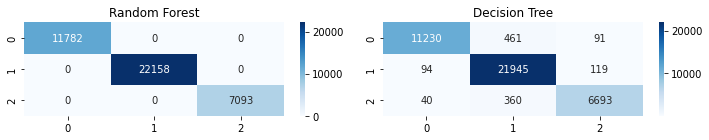

In [34]:
#Plotting Confusion-Matrix of all the predictive Models

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels 
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3.5*math.ceil(len(all_models)*len(labels)/14)])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/3),3,i+1)
        pred = all_models[i].predict(x_test)
        sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([rf_model,dt_model])